[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

In [5]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

Vamos a utilizar el mismo dataset que conocemos de posts anteriores, el dataset `VOC`.

In [7]:
# train = torchvision.datasets.VOCDetection('./data', download=True)
# len(train)

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import os

ruta = '/content/drive/MyDrive/ProyectoSegundoParcialIA2/'  # Ruta de la carpeta que deseas listar

archivos = os.listdir(ruta)

for archivo in archivos:
    print(archivo)


bolsa
json
Copia de cv_ssd_corregido_(2) (7)00.ipynb


In [10]:
import json
data= open("/content/drive/MyDrive/ProyectoSegundoParcialIA2/json/bolsa.json")
datajson = json.load(data)


In [11]:
datajson[0]

{'annotation': {'filename': 'bolsa0966.jpg',
  'size': {'width': '800', 'height': '600', 'depth': '3'},
  'object': [{'name': 'bolsa',
    'bndbox': {'top': 30.0, 'left': 29.0, 'height': 527.0, 'width': 387.0}},
   {'name': 'bolsa',
    'bndbox': {'top': 82.0, 'left': 325.0, 'height': 507.0, 'width': 468.0}}]}}

In [12]:
# Extraer las imágenes y las etiquetas del JSON
train_imgs = [example['annotation']['filename'] for example in datajson]
train_labels = [example['annotation']['object'][0]['name'] for example in datajson]


In [13]:
train_imgs[0]

'bolsa0966.jpg'

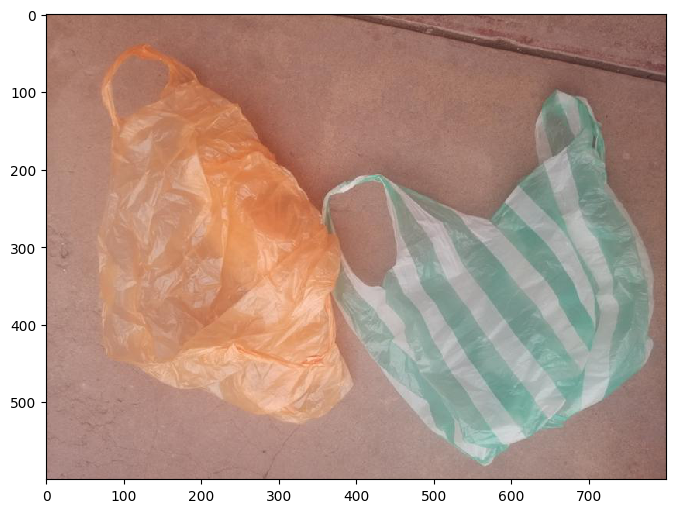

In [14]:
image = np.array(Image.open("/content/drive/MyDrive/ProyectoSegundoParcialIA2/bolsa/bolsa/"+train_imgs[0]).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

In [25]:
import os 
import cv2
from tqdm import tqdm
import numpy as np
from random import sample
from PIL import Image
import json

PATH = '/content/drive/MyDrive/ProyectoSegundoParcialIA2/bolsa/'
classes = os.listdir(PATH)
classes = sorted(classes)  # Ordena las carpetas alfabéticamente
print(classes)

json_folder = "/content/drive/MyDrive/ProyectoSegundoParcialIA2/json/"
classes_json = os.listdir(json_folder)
classes_json = sorted(classes_json)  # Ordena los archivos JSON alfabéticamente
print(classes_json)


['ImagenesRotadas', 'bolsa']
['ImagenesRotadas.json', 'bolsa.json']


In [26]:
# import json
# data= open("/content/drive/MyDrive/ProyectoSegundoParcialIA2/json/basura_labels.json")
# datajson = json.load(data)

In [27]:
#PATH = '/content/drive/MyDrive/ProyectoSegundoParcialIA2/bolsa/bolsa/'

In [28]:
# from random import sample
# from PIL import Image
# import numpy as np

# def loadImages(datajson, split=0.1):
#     img_test_ = []
#     img_train_ = []
#     labels_test_ = []
#     labels_train_ = []
#     data_ = datajson
#     test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
#     for i, example in enumerate(data_):
#         image_filename = example['annotation']['filename']
#         image_path = PATH + image_filename
#         #image_load_ = Image.open(image_path).convert('RGB')
#         #image_ = np.array(image_load_) / 255
#         if i not in test_ids:
#             img_train_.append(image_path)
#             #labels_train_.append(example['annotation'])
#             labels_train_.append(example)
#         else:
#             img_test_.append(image_path)
#             #labels_test_.append(example['annotation'])
#             labels_test_.append(example)
#     return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [38]:
def loadImages(data_folder, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    
    for image_class, json_class in zip(classes, classes_json):
        class_path = os.path.join(data_folder, image_class)
        json_path = os.path.join(json_folder, json_class)
        
        with open(json_path) as json_file:
            datajson = json.load(json_file)
        
        test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
        for i, example in enumerate(datajson):
            image_filename = example['annotation']['filename']
            image_path = os.path.join(class_path ,image_filename)
            example['annotation']['class'] = 'Nueva Clase'
            
            if i not in test_ids:
                img_train_.append(image_path)
                labels_train_.append(example)
            else:
                img_test_.append(image_path)
                labels_test_.append(example)
    
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

img_train, img_test, labels_train, labels_test = loadImages(PATH, split=0.1)
len(img_train), len(labels_train)



(1864, 1864)

In [39]:
# import os

# def loadImages(data_folder, split=0.1):
#     img_test_ = []
#     img_train_ = []
#     labels_test_ = []
#     labels_train_ = []
    
#     for image_class, json_class in zip(classes, classes_json):
#         class_path = os.path.join(data_folder, image_class)
#         json_path = os.path.join(json_folder, json_class)
        
#         with open(json_path) as json_file:
#             datajson = json.load(json_file)
        
#         test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
#         for i, example in enumerate(datajson):
#             image_filename = example['annotation']['filename']
#             image_name = os.path.splitext(image_filename)[0]  # Obtener el nombre del archivo sin la extensión
            
#             image_path = os.path.join(class_path, image_filename)
#             example['annotation']['class'] = 'Nueva Clase'
            
#             if image_name in img_train_ or image_name in img_test_:
#                 print(f"El nombre de archivo {image_filename} está duplicado. Verifica tus datos.")
            
#             if i not in test_ids:
#                 img_train_.append(image_name)
#                 labels_train_.append(example)
#             else:
#                 img_test_.append(image_name)
#                 labels_test_.append(example)
    
#     return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)


In [40]:
# import os

# def loadImages(data_folder, split=0.1):
#     img_test_ = []
#     img_train_ = []
#     labels_test_ = []
#     labels_train_ = []
    
#     for image_class, json_class in zip(classes, classes_json):
#         class_path = os.path.join(data_folder, image_class)
#         json_path = os.path.join(json_folder, json_class)
        
#         with open(json_path) as json_file:
#             datajson = json.load(json_file)
        
#         test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
#         for i, example in enumerate(datajson):
#             image_filename = example['annotation']['filename']
#             image_name, image_ext = os.path.splitext(image_filename)  # Separar el nombre de archivo y la extensión
            
#             if image_name != image_class:  # Verificar si el nombre del archivo no coincide con el nombre de la carpeta
#                 print(f"El nombre del archivo {image_filename} no coincide con el nombre de la carpeta {image_class}.")
#                 continue
            
#             image_path = os.path.join(class_path, image_filename)
#             example['annotation']['class'] = 'Nueva Clase'
            
#             if i not in test_ids:
#                 img_train_.append(image_path)
#                 labels_train_.append(example)
#             else:
#                 img_test_.append(image_path)
#                 labels_test_.append(example)
    
#     return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)


In [41]:
img_train, img_test, labels_train, labels_test = loadImages(PATH, split=0.1)

In [42]:
len(img_train), len(labels_train)

(1864, 1864)

In [43]:
img_train[2] , labels_train[2]

('/content/drive/MyDrive/ProyectoSegundoParcialIA2/bolsa/ImagenesRotadas/bolsa0968_R270.jpg',
 {'annotation': {'filename': 'bolsa0968_R270.jpg',
   'size': {'width': 600, 'height': 800, 'depth': '3'},
   'object': [{'name': 'bolsa',
     'bndbox': {'top': 123.0, 'left': 64.0, 'height': 555.0, 'width': 479.0}}],
   'class': 'Nueva Clase'}})

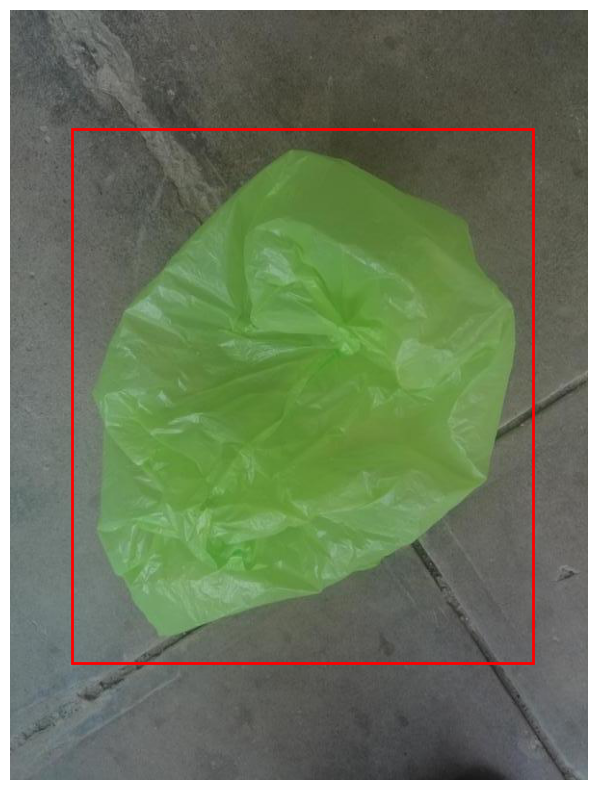

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Obtener la ruta de la imagen y las etiquetas
image_path = img_train[2]
labels = labels_train[2]

# Cargar la imagen
image = Image.open(image_path)

# Crear una figura y un objeto de eje
fig, ax = plt.subplots()

# Mostrar la imagen en el eje
ax.imshow(image)
ax.axis('off')

# Obtener las coordenadas del cuadro delimitador
bndboxes = labels['annotation']['object']
for bndbox in bndboxes:
    # Obtener las coordenadas del cuadro delimitador
    x = int(bndbox['bndbox']['left'])
    y = int(bndbox['bndbox']['top'])
    width = int(bndbox['bndbox']['width'])
    height = int(bndbox['bndbox']['height'])

    # Crear un rectángulo y agregarlo al eje
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Mostrar la imagen y los rectángulos en pantalla
plt.show()

In [45]:
import torch
from skimage import io
device = "cuda" if torch.cuda.is_available() else "cpu"
from skimage import color
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # if img.shape[2] == 4:
    #   img = color.rgba2rgb(img)
    # aplicar transformaciones
    #print(f"imagen: {img}")
    # if self.trans:
    #   img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float(), self.y[ix]
    #return img, self.y[ix]


In [46]:
import albumentations as A

trans = A.Compose([
    A.Resize(800, 600)
])

dataset = {
    'train': Dataset(img_train, labels_train , trans, device), 
    'test': Dataset(img_test ,labels_test , trans, device)
}

len(dataset['train']), len(dataset['test'])

(1864, 206)

In [47]:
dataset['train'][0]

(tensor([[[0.6314, 0.4941, 0.4784],
          [0.6510, 0.5137, 0.4980],
          [0.6627, 0.5255, 0.5098],
          ...,
          [0.6039, 0.4196, 0.3569],
          [0.5882, 0.4039, 0.3412],
          [0.5804, 0.3961, 0.3333]],
 
         [[0.6431, 0.5059, 0.4902],
          [0.6549, 0.5176, 0.5020],
          [0.6706, 0.5333, 0.5176],
          ...,
          [0.6078, 0.4235, 0.3608],
          [0.5961, 0.4118, 0.3490],
          [0.5882, 0.4039, 0.3412]],
 
         [[0.6627, 0.5255, 0.5098],
          [0.6667, 0.5294, 0.5137],
          [0.6745, 0.5373, 0.5216],
          ...,
          [0.6118, 0.4275, 0.3647],
          [0.6078, 0.4235, 0.3608],
          [0.6039, 0.4196, 0.3569]],
 
         ...,
 
         [[0.5216, 0.3843, 0.3608],
          [0.5098, 0.3725, 0.3490],
          [0.5020, 0.3647, 0.3412],
          ...,
          [0.5137, 0.3647, 0.3294],
          [0.5216, 0.3725, 0.3373],
          [0.5176, 0.3686, 0.3333]],
 
         [[0.5176, 0.3804, 0.3569],
          [0

In [48]:
classes = ["background","bolsa",'ImagenesRotadas']

In [49]:
dataset['train'][1]

(tensor([[[0.4549, 0.4510, 0.4431],
          [0.4549, 0.4510, 0.4431],
          [0.4549, 0.4510, 0.4431],
          ...,
          [0.2902, 0.2510, 0.2118],
          [0.2980, 0.2588, 0.2196],
          [0.2902, 0.2510, 0.2118]],
 
         [[0.4745, 0.4706, 0.4627],
          [0.4745, 0.4706, 0.4627],
          [0.4706, 0.4667, 0.4588],
          ...,
          [0.2941, 0.2549, 0.2157],
          [0.2980, 0.2588, 0.2196],
          [0.2902, 0.2510, 0.2118]],
 
         [[0.4980, 0.4941, 0.4863],
          [0.4941, 0.4902, 0.4824],
          [0.4863, 0.4824, 0.4745],
          ...,
          [0.3020, 0.2627, 0.2235],
          [0.3020, 0.2627, 0.2235],
          [0.2902, 0.2510, 0.2118]],
 
         ...,
 
         [[0.4510, 0.4510, 0.4510],
          [0.4510, 0.4510, 0.4510],
          [0.4510, 0.4510, 0.4510],
          ...,
          [0.4431, 0.4235, 0.4078],
          [0.4392, 0.4196, 0.4039],
          [0.4314, 0.4118, 0.3961]],
 
         [[0.4510, 0.4510, 0.4510],
          [0

In [56]:
def convert_to_oriented_bbox(anns):
    labels, bbs = anns
    oriented_bbs = []

    for bb in bbs:
        x, y, width, height = bb

        x1 = x
        y1 = y
        x2 = x + width
        y2 = y
        x3 = x + width
        y3 = y + height
        x4 = x
        y4 = y + height

        oriented_bb = (x1, y1, x2, y2, x3, y3, x4, y4)
        oriented_bbs.append(oriented_bb)

    return (labels, oriented_bbs)

In [57]:
def convert_to_xmin_xmax_ymin_ymax(top, left, height, width):
    xmin = left
    xmax = left + width
    ymin = top
    ymax = top + height
    return xmin, xmax, ymin, ymax

In [63]:
bg = -1
ax = None
img_np, label = dataset['train'][1]
#img_np = np.array(img)
anns = label['annotation']['object']
if type(anns) is not list:
  anns = [anns]
labels = np.array([classes.index(ann['name']) for ann in anns])

bbs = []
for ann in anns:
    bb = ann['bndbox']
    xmin, xmax, ymin, ymax = convert_to_xmin_xmax_ymin_ymax(int(bb['top']), int(bb['left']), int(bb['height']), int(bb['width']))
    bbs.append([xmin, ymin, xmax, ymax])

bbs = np.array(bbs)

anns = (labels, bbs)

In [59]:
# bg=-1
# ax=None
# img_np, label = dataset['train'][1]
# #img_np = np.array(img)
# anns = label['annotation']['object']
# if type(anns) is not list:
#   anns = [anns]
# labels = np.array([classes.index(ann['name']) for ann in anns])
# bbs = [ann['bndbox'] for ann in anns]

# bbs = np.array([[convert_to_xmin_xmax_ymin_ymax(int(bb['top']), int(bb['left']), int(bb['height']), int(bb['width'])) for bb in bbs]])

# anns = (labels, bbs)
# # print(anns)
# # anns = convert_to_oriented_bbox(anns)
# # print(anns)
# # print(type(anns))
# anns

(array([1]), array([[[ 28, 600, 143, 636]]]))

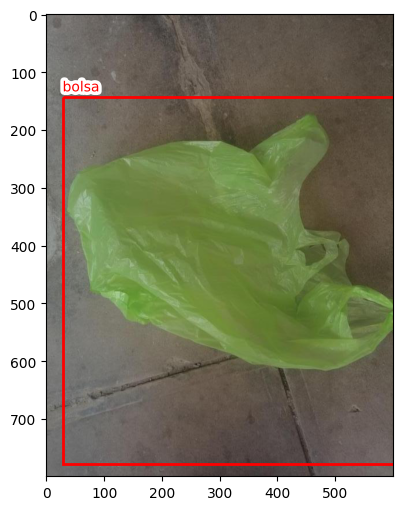

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_np)
labels, bbs = anns
for lab, bb in zip(labels, bbs):
  if bg == -1 or lab != bg:
    x, y, w, h = bb
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

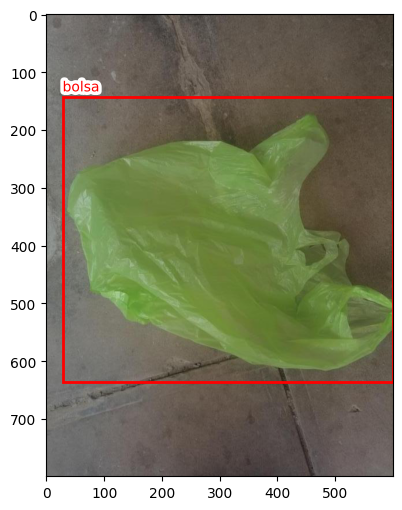

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_np)
labels, bbs = anns
for lab, bb in zip(labels, bbs):
  if bg == -1 or lab != bg:
    x, y, xm, ym = bb
    w, h = xm - x, ym - y
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

In [66]:
# anns  =convert_to_x_y_w_h1(anns)
# print(anns)

NameError: ignored

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib.patheffects as PathEffects
# import random

# def get_sample(ix):
#   img_np, label = dataset['train'][ix]
  
#   #img_np = np.array(img)
#   anns = label['annotation']['object']
#   if type(anns) is not list:
#     anns = [anns]
#   labels = np.array([classes.index(ann['name']) for ann in anns])
#   bbs = [ann['bndbox'] for ann in anns]
#   bbs = np.array([[int(bb['left']), int(bb['top']),int(bb['width']),int(bb['height'])] for bb in bbs])
  
#   anns = (labels, bbs)
  
#   return img_np, anns

In [67]:
def get_sample(ix):
  img_np, label = dataset['train'][ix]
  #img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = []
  for ann in anns:
      bb = ann['bndbox']
      xmin, xmax, ymin, ymax = convert_to_xmin_xmax_ymin_ymax(int(bb['top']), int(bb['left']), int(bb['height']), int(bb['width']))
      bbs.append([xmin, ymin, xmax, ymax])
  bbs = np.array(bbs)
  anns = (labels, bbs)
  return img_np, anns

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.patheffects as PathEffects

# def plot_anns(img, anns, ax=None, bg=-1):
#   if not ax:
#     fig, ax = plt.subplots(figsize=(10, 6))
#   ax.imshow(img)
#   labels, bbs = anns
#   for lab, bb in zip(labels, bbs):
#     if bg == -1 or lab != bg:
#       x, y, w, h = bb
#       rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
#       text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
#       text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
#       ax.add_patch(rect)


In [68]:
def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb
      w, h = xm - x, ym - y
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

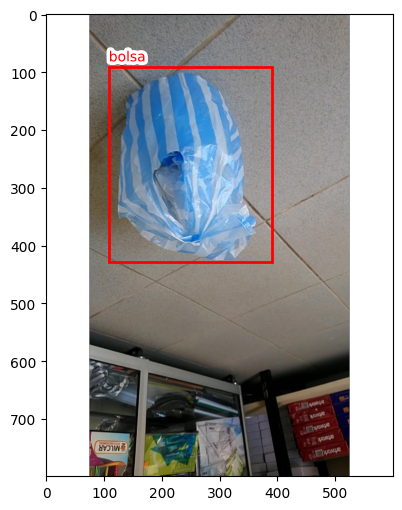

In [69]:
ix = random.randint(0,1035)
ix=600
image, anns = get_sample(ix)
plot_anns(image, anns)

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [70]:
# classes = ["background","aeroplane","bicycle","bird","boat",
# "bottle","bus","car","cat","chair","cow","diningtable","dog",
# "horse","motorbike","person","pottedplant","sheep","sofa",
# "train","tvmonitor"]

In [71]:
# classes = ["background","bolsa",""]

Las siguientes funciones nos ayudan a extraer la información que necesitamos de las anotaciones y a visualizar muestras del dataset.

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [72]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

#def xywh2xyxy(bb):
#  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

In [73]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  # anns is a tuple with (bbs, labels)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    x, y, xm, ym = bb
    w, h = xm - x, ym - y
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)
  # for lab, bb in zip(labels, bbs):    
  #   x, y, w, h = bb
  #   rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
  #   text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
  #   text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
  #   ax.add_patch(rect)

<ipython-input-72-94038b129dcb>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()


(138, [3, 3, 3])

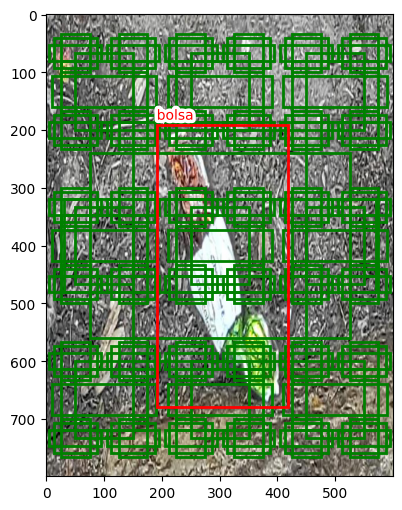

In [74]:
ix = 700
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [6, 3, 1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors), k

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [75]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

  
    #return o2l, o2c

In [76]:
!git clone https://github.com/nachiket273/pytorch_resnet_rs.git

fatal: destination path 'pytorch_resnet_rs' already exists and is not an empty directory.


In [77]:
import sys
sys.path.append('/content/pytorch_resnet_rs')

from model import ResnetRS

In [78]:
model = ResnetRS.create_pretrained('resnetrs50', in_ch=1, num_classes=2,
                           drop_rate=0)
model.eval()

Resnet(
  (conv1): StemBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actn1): ReLU(inplace=True)
    (maxpool): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): C

In [79]:
model = torch.nn.Sequential(*list(model.children())[:-1])
model

Sequential(
  (0): StemBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actn1): ReLU(inplace=True)
    (maxpool): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d

In [100]:
class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
    super().__init__()
    # backbone
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 64)
    self.conv6 = block(64, 64)
    # head
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
    # backbone
    print(x.shape) 
    x = self.conv1(x)
    print(x.shape)
    x = self.conv2(x)
    print(x.shape)
    x = self.conv3(x)     # para inputs de 100x100
    print(x.shape)
    x4 = self.conv4(x)    # 6x6
    print(x.shape)
    x5 = self.conv5(x4)   # 3x3
    print(x.shape)
    x6 = self.conv6(x5)   # 1x1
    print(x.shape)

    # head
    o1l, o1c = self.out4(x4)
    print(x.shape)
    o2l, o2c = self.out5(x5)
    print(x.shape)
    o3l, o3c = self.out6(x6)
    print(x.shape)
    return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)  

In [101]:
net = SSD(n_classes=len(classes), k=k)
# Realizar una prueba del forward
input_tensor = torch.rand((64, 3, 100, 100))
output = net(input_tensor)
output[0].shape, output[1].shape

torch.Size([64, 3, 100, 100])
torch.Size([64, 8, 50, 50])
torch.Size([64, 16, 25, 25])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])
torch.Size([64, 32, 12, 12])


(torch.Size([64, 138, 4]), torch.Size([64, 138, 3]))

In [113]:
import torch
import torch.nn as nn
def block2(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )
class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
    super().__init__()
    # restnerxt_50  2048
    resnetrs50 = ResnetRS.create_pretrained('resnetrs50', in_ch=n_channels, num_classes=n_classes,
                           drop_rate=0)
    self.resnetrs50 = torch.nn.Sequential(*list(resnetrs50.children())[:-1])
    self.conv3 = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
    # self.conv2 = block(64, 64)
    # self.conv5 = block(64, 64)
    # self.conv6 = block(64, 64)
    # head
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
      print(x.shape)
      x = self.resnetrs50(x)
      # print(x.shape)
      # x = self.conv3(x)
      print(x.shape)
      x4 = self.conv4(x)
      print(x.shape)
      x5 = self.conv5(x4)
      x6 = self.conv6(x5)
      
      o1l, o1c = self.out4(x4)
      o2l, o2c = self.out5(x5)
      o3l, o3c = self.out6(x6)
      
      return torch.cat([o1l, o2l, o3l], dim=1), torch.cat([o1c, o2c, o3c], dim=1)


In [1]:
import torch
import torch.nn as nn

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

class SSD(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
        super().__init__()

        # ResnetRS50
        resnetrs50 = ResnetRS.create_pretrained('resnetrs50', in_ch=n_channels, num_classes=n_classes, drop_rate=0)
        self.resnetrs50 = torch.nn.Sequential(*list(resnetrs50.children())[:-2])
        
        # self.conv4 = block(2048, 2048)
        # self.conv5 = block(2048, 2048)
        # self.conv6 = block(2048, 2048)

        # head
        self.k = k
        self.out4 = out_conv(64, self.k[0], n_classes)
        self.out5 = out_conv(64, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

    def forward(self, x):
        print(x.shape)
        x = self.resnetrs50(x)
        # print(x.shape)
        # x = self.conv4(x)
        # print(x.shape)
        # x = self.conv5(x)
        # print(x.shape)
        # x = self.conv6(x)
        print(x.shape)
        o1l, o1c = self.out4(x)
        print(x.shape)
        o2l, o2c = self.out5(o1l)
        print(x.shape)
        o3l, o3c = self.out6(o2l)
        print(x.shape)
        
        return torch.cat([o1l, o2l, o3l], dim=1), torch.cat([o1c, o2c, o3c], dim=1)


In [2]:
net = SSD(n_classes=len(classes), k=k)
# Realizar una prueba del forward
input_tensor = torch.rand((64, 3, 100, 100))
output = net(input_tensor)
output[0].shape, output[1].shape

NameError: ignored

In [ ]:
net = SSD(n_classes=len(classes), k=k)
# Realizar una prueba del forward
input_tensor = torch.rand((64, 3, 100, 100))
output = net(input_tensor)
output[0].shape, output[1].shape

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 21 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% del tamaños de la caja en ambas dimensiones.

In [ ]:
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante. También puede ocurrir que no haya ninguna caja que cumpla estos requisitos, es este caso le asignaremos aquella con mayor `IoU`.

In [ ]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [ ]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()
        self.class_loss = torch.nn.CrossEntropyLoss()
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0]
                tar_idx = gt_idx[pos_idx]
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                _anchors = pred_bb[pos_idx]
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

## Entrenamiento

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [ ]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles. Utilizamos albumentations para hacer el *resize* de la imagen y anotaciones.

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
img_np = np.array(img_np)
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})

img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [ ]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

In [ ]:
model = SSD(n_classes = len(classes), k=k)
outputs = model(torch.randn(64, 3, 224, 224))


In [ ]:
fit(model, img_tensor, (bb_tensor, label_tensor), epochs=100)

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [ ]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

In [ ]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

In [ ]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [ ]:
bbs, (scores, labels) = predict(model, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

In [ ]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

In [ ]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.